**Implementing D-MAB, as described in DaCosta et al. - 2008 - Adaptive operator selection with dynamic multi-arm**

>  (hybrid between UCB1 and Page-Hinkley (PH) test)

D-MAB maintains four indicators for each arm $i$:
1. number $n_{i, t}$ of times $i$-th arm has been played up to time $t$;
2. the average empirical reward $\widehat{p}_{j, t}$ at time $t$;
3. the average and maximum deviation $m_i$ and $M_i$ involved in the PH test, initialized to $0$ and updated as detailed below. At each time step $t$:

D-MAB selects the arm $i$ that maximizes equation 1:

$$\widehat{p}_{i, t} + \sqrt{\frac{2 \log \sum_{k}n_{k, t}}{n_{i, t}}}$$

> Notice that the sum of the number of times each arm was pulled is equal to the time $\sum_{k}n_{k, t} = t$, but since their algorithm resets the number of picks, we need to go with the summation. 

and receives some reward $r_t$, drawn after reward distribution $p_{i, t}$.

> I think there is a typo in the eq. 1 on the paper. I replaced $j$ with $i$ in the lower indexes.

The four indicators are updated accordingly:

- $\widehat{p}_{i, t} :=\frac{1}{n_{i, t} + 1}(n_{i, t}\widehat{p}_{i, t} + r_t)$
- $n_{i, t} := n_{i, t}+1$
- $m_i := m_i + (\widehat{p}_{i, t} - r_t + \delta)$
- $M_i:= \text{max}(M_i, m_i)$

And if the PH test is triggered ($M_i - m_i > \lambda$), the bandit is restarted, i.e., for all arms, all indicators are set to zero (the authors argue that, empirically, resetting the values is more robust than decreasing them with some mechanism such as probability matching).

> I will reset to 1 instead of 0 (as the original paper does) to avoid divide by zero when calculating UCB1.

The PH test is a standard test for the change hypothesis. It works by monitoring the difference between $M_i$ and $m_i$, and when the difference is greater than some uuser-specified threshold $\lambda$, the PH test is triggered, i.e., it is considered that the Change hypothesis holds.

Parameter $\lambda$ controls the trade-off between false alarms and un-noticed changes. Parameter $\delta$ enforces the robustness of the test when dealing with slowly varying environments.

We also need a scaling mechanism to control the Exploration _versus_ Exploitation balance. They proposed two, from which I will focus on the first: Multiplicative Scaling (cUCB). **It consists on multiplying all rewards by a fixed user-defined parameter $C_{M-\text{scale}}$.

This way, we need to give to our D-MAB 3 parameters: $\lambda$, $\delta$, and $C_{M - \text{scale}}$. In the paper they did a sensitivity analysis of the parameters, but I think they should be fine tuned for each specific data set.

> Brush originally sample the mutations using an uniform distribution. This algorithm chooses the arms using an deterministic approach --- the one that maximizes the UCB1 score. Somehow we need to convert them to have a transparent implementation to the user.

In [1]:
import numpy as np

# TODO: update this to work with optional mutation
class D_MAB:
    def __init__(self, num_bandits, delta=0.15, lmbda=0.25):
        self.num_bandits = num_bandits

        # Store learner status when the update function is called
        self.pull_history = {
            c:[] for c in ['t', 'arm idx', 'reward', 'update'] + 
                          [f'UCB1 {i}' for i in range(num_bandits)]} 


        # This is the probability that should be used to update brush probs
        self._probabilities = np.ones(num_bandits)/num_bandits

        self.delta = delta # how to define these values???
        self.lmbda = lmbda

        self._reset_indicators() # Creating the indicators 

    def _reset_indicators(self):
        self._avg_rewards    = np.zeros(self.num_bandits)
        self._num_pulls      = np.zeros(self.num_bandits)
        self._avg_deviations = np.zeros(self.num_bandits)
        self._max_deviations = np.zeros(self.num_bandits)

    def _calculate_UCB1s(self):
        # We need that the reward is in [0, 1] (not avg_reward, as it seems to
        # render worse results). It looks like normalizing the rewards is a
        # problem: reward should be [0, 1], but not necessarely avg_rewards too
        rs = self._avg_rewards
        ns = self._num_pulls
        
        UCB1s = rs + np.sqrt(2*np.log1p(sum(ns))/(ns+1))

        return UCB1s

    @property
    def probabilities(self):
        # How to transform our UCB1 scores into node probabilities?
        return self._probabilities
    
    @probabilities.setter
    def probabilities(self, new_probabilities):
        if len(self._probabilities)==len(new_probabilities):
            self._probabilities = new_probabilities
        else:
            print(f"New probabilities must have size {self.num_bandits}")

    def choose_arm(self):
        """Uses previous recordings of rewards to pick the arm that maximizes
        the UCB1 function. The choice is made in a deterministic way.
        """

        UCB1s = self._calculate_UCB1s()

        return np.nanargmax(UCB1s)

    def update(self, arm_idx, reward):
        # Here we expect that the reward was already scaled to be in the 
        # interval [0, 1] (in the original paper, they sugest using a scaling
        # factor as an hyperparameter).

        self.pull_history['t'].append( len(self.pull_history['t']) )
        self.pull_history['arm idx'].append( arm_idx )
        self.pull_history['reward'].append( reward )

        for i, UCB1 in enumerate(self._calculate_UCB1s()):
            self.pull_history[f'UCB1 {i}'].append( UCB1 )

        if np.isfinite(reward):
            self._avg_rewards[arm_idx]    = \
                (self._num_pulls[arm_idx]*self._avg_rewards[arm_idx] + reward)/(self._num_pulls[arm_idx]+1)
            self._avg_deviations[arm_idx] = \
                self._avg_deviations[arm_idx] + (self._avg_rewards[arm_idx] - reward + self.delta)
            
        self._num_pulls[arm_idx]    = self._num_pulls[arm_idx] +1
        self._max_deviations[arm_idx] = \
            np.maximum(self._max_deviations[arm_idx], self._avg_deviations[arm_idx])

        if (self._max_deviations[arm_idx] - self._avg_deviations[arm_idx] > self.lmbda):
            self._reset_indicators()
            self.pull_history['update'].append( 1 )
        else:
            self.pull_history['update'].append( 0 )

        return self

Below I'll create a simple bandit configuration so we can do a sanity check of our `D_MAB` implementation.

In [2]:
# Sanity checks
import pandas as pd

class Bandits:
    def __init__(self, reward_prob):
        # Implementing simple bandits.
        self.reward_prob = reward_prob # True reward prob., which learner shoudn't know
        self.n_bandits   = len(reward_prob) 

    def pull(self, arm_idx):
        # Sampling over a normal distr. with mu=0 and var=1
        result = np.random.randn()
        
        # return a positive or nullary reward (Bernoulli random variable).
        return 1.0 if result > self.reward_prob[arm_idx] else 0.0

for probs, descr, expec in [
    (np.array([ 1.0,  1.0, 1.0,  1.0]), 'All bandits with same probs'  , 'similar amount of pulls for each arm'         ),
    (np.array([-1.0,  0.2, 0.0,  1.0]), 'One bandit with higher prob'  , 'more pulls for first arm, less pulls for last'),
    (np.array([-0.2, -1.0, 0.0, -1.0]), 'Two bandits with higher probs', '2nd approx 4th > 1st > 3rd'                   ),
]:
    bandits = Bandits(probs)

    print("------------------------ optimizing ------------------------")

    learner = D_MAB(4)
    for i in range(1000):
        arm_idx = learner.choose_arm()
        reward  = bandits.pull(arm_idx)

        learner.update(arm_idx, reward) 

    learner_log = pd.DataFrame(learner.pull_history).set_index('t')

    total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
    total_pulls   = learner_log['arm idx'].value_counts().to_dict()

    print("cum. reward for each arm    : ", total_rewards)
    print("number of pulls for each arm: ", total_pulls)
    print(f"(it was expected: {expec})")

------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 40.0, 1: 41.0, 2: 37.0, 3: 33.0}
number of pulls for each arm:  {0: 278, 1: 255, 2: 247, 3: 220}
(it was expected: similar amount of pulls for each arm)
------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 441.0, 1: 73.0, 2: 103.0, 3: 16.0}
number of pulls for each arm:  {0: 514, 2: 207, 1: 179, 3: 100}
(it was expected: more pulls for first arm, less pulls for last)
------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 105.0, 1: 266.0, 2: 61.0, 3: 295.0}
number of pulls for each arm:  {3: 358, 1: 324, 0: 186, 2: 132}
(it was expected: 2nd approx 4th > 1st > 3rd)


Ok, so the D-MAB seems to work. Now let's add this MAB inside mutation to update PARAMS option and control dinamically the mutaiton probabilities during evolution.

We can import the brush estimator and replace the `_mutation` by a custom function. Ideally, to use this python MAB optimizer, we need to have an object created to keep track of the variables, and the object needs to wrap the _pull_ action, as well as evaluating the reward based on the result.

> we'll need to do a _gambiarra_ to know which mutation is used so we can correctly update `D_MAB`. All MAB logic is implemented in python, and we chose the mutation in python as well. To make sure a specific mutation was used, we force it to happen by setting others' weights to zero. this way we know exactly what happened in the C++ code

In [3]:
from brush.estimator import BrushEstimator
from sklearn.base import ClassifierMixin, RegressorMixin
from deap import creator
import _brush
from deap_api import nsga2 

class BrushEstimatorMod(BrushEstimator): # Modifying brush estimator
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # mutations optimized by the learner. Learner arms correspond to
        # these mutations in the order they appear here
        self.mutations_ = ['point', 'insert', 'delete', 'toggle_weight']

        # Whether the learner should update after each mutation, or if it should
        # update only after a certain number of evaluations.
        # Otherwise, it will
        # store all rewards in gen_rewards_ (which is reseted at the beggining
        # of every generation) and do a batch of updates only after finishing
        # mutating the solutions.
        self.batch_size_    = self.pop_size*2 #
        self.batch_rewards_ = []

    def _mutate(self, ind1):
        # Overriding the mutation so it updates our sampling method. Doing the
        # logic on the python-side for now.

        # Creating a wrapper for mutation to be able to control what is happening
        # in the C++ code (this should be prettier in a future implementation)
        
        params = self.get_params()
        
        ignore_this_time = True if (ind1.prg.size()+1>=self.max_size
                                    or ind1.prg.depth()+1>=self.max_depth) else False

        # Insert Mutation will not work, even if we force it, when the expression
        # is already at maximum size.
        # In this case, we'll do the mutation without controlling the probabilities.
        if ignore_this_time:
            for i, m in enumerate(self.mutations_):
                params['mutation_options'][m] = 0.25 # let cpp do the mutation 
        else:
            mutation_idx = self.learner_.choose_arm()

            for i, m in enumerate(self.mutations_):
                params['mutation_options'][m] = 0 if i != mutation_idx else 1.0

        _brush.set_params(params)
    
        # ind1.prg.mutate is a convenient interface that uses the current search 
        # space to sample mutations
        offspring = creator.Individual(ind1.prg.mutate())

        offspring.fitness.values = self.toolbox_.evaluate(offspring)
        
        # We compare fitnesses using the deap overloaded operators
        # from the docs: When comparing fitness values that are **minimized**,
        # ``a > b`` will return :data:`True` if *a* is **smaller** than *b*.
        # (this means that this comparison should work agnostic of min/max problems,
        # or even a single-objective or multi-objective problem)
        reward = 1.0 if offspring.fitness > ind1.fitness else 0.0
        
        if not ignore_this_time:
            self.batch_rewards_.append( (mutation_idx, reward) )
        
        if len(self.batch_rewards_) > self.batch_size_:
            for (mutation_idx, reward) in self.batch_rewards_:
                self.learner_.update(mutation_idx, reward)
            self.batch_rewards_ = []
            
        return offspring
    
    def fit(self, X, y):

        _brush.set_params(self.get_params())

        self.data_ = self._make_data(X,y)
        # self.data_.print()

        # set n classes if relevant
        if self.mode=="classification":
            self.n_classes_ = len(np.unique(y))

        # We have 4 different mutations, and the learner will learn to choose
        # between these options by maximizing the reward when using each one
        self.learner_ = D_MAB(4)

        if isinstance(self.functions, list):
            self.functions_ = {k:1.0 for k in self.functions}
        else:
            self.functions_ = self.functions

        self.search_space_ = _brush.SearchSpace(self.data_, self.functions_)

        self.toolbox_ = self._setup_toolbox(data=self.data_)

        archive, logbook = nsga2(
            self.toolbox_, self.max_gen, self.pop_size, 0.9, self.verbosity)

        self.archive_ = archive
        self.logbook_ = logbook
        self.best_estimator_ = self.archive_[0].prg

        return self
    

class BrushClassifierMod(BrushEstimatorMod,ClassifierMixin):
    def __init__( self, **kwargs):
        super().__init__(mode='classification',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.abs(data.y-ind.prg.predict(data)).sum(), 
            ind.prg.size()
        )
    
    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_classifier(self.max_depth, self.max_size)
            if self.n_classes_ == 2 else
            self.search_space_.make_multiclass_classifier(self.max_depth, self.max_size)
            )

    def predict_proba(self, X):
        data = self._make_data(X)
        return self.best_estimator_.predict_proba(data)


class BrushRegressorMod(BrushEstimatorMod, RegressorMixin):
    def __init__(self, **kwargs):
        super().__init__(mode='regressor',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.sum((data.y- ind.prg.predict(data))**2),
            ind.prg.size()
        )

    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_regressor(self.max_depth, self.max_size)
        )

## Regression problem

In [4]:
# This is needed to avoid racing conditions (https://deap.readthedocs.io/en/master/tutorials/basic/part4.html)
if __name__ == '__main__':
    from brush import BrushRegressor
    
    import warnings
    warnings.filterwarnings("ignore")

    # data = pd.read_csv('../../docs/examples/datasets/d_enc.csv')
    # X = data.drop(columns='label')
    # y = data['label']

    # data = pd.read_csv('../../docs/examples/datasets/d_2x1_subtract_3x2.csv')
    # X = data.drop(columns='target')
    # y = data['target']

    data = pd.read_csv('../../docs/examples/datasets/d_square_x1_plus_2_x1_x2_plus_square_x2.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'verbosity' : False,
        'pop_size'  : 100,
        'max_gen'   : 100,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    results = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
         ('Original', 'size'),  ('Original', 'depth'), 
         ('Modified', 'score'), ('Modified', 'best model'), 
         ('Modified', 'size'),  ('Modified', 'depth'), 
         ('Modified', 'point mutation calls'),
         ('Modified', 'insert mutation calls'),
         ('Modified', 'delete mutation calls'),
         ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')

            est     = BrushRegressor(**kwargs).fit(X,y)
            est_mab = BrushRegressorMod(**kwargs).fit(X,y)

            learner_log = pd.DataFrame(est_mab.learner_.pull_history).set_index('t')
                        
            total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
            total_pulls   = learner_log['arm idx'].value_counts().to_dict()
            
            results.loc[f'run {i}'] = [
                # Original implementation
                est.score(X,y), est.best_estimator_.get_model(),
                est.best_estimator_.size(), est.best_estimator_.depth(),

                # Implementation using Dynamic Thompson Sampling
                est_mab.score(X,y), est_mab.best_estimator_.get_model(), 
                est_mab.best_estimator_.size(), est_mab.best_estimator_.depth(),
                
                # Mutation count
                *total_pulls.values()]
            
        except Exception as e:
            print(e)

    # Showing results and statistics
    display(results)
    display(results.describe())

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 


Brush version  Original                                                    
metric            score                            best model size depth   
run 0          0.490733  Square(If(x1>0.91,1.34*x1,-0.85*x1))    4     2  \
run 1          0.325058                         Cos(-1.72*x2)    2     1   
run 2          0.325058                          Cos(1.72*x2)    2     1   
run 3          0.325058                         Cos(-1.72*x2)    2     1   
run 4          0.198205                          Abs(0.74*x1)    2     1   
run 5          0.314972                    0.51*Acos(1.10*x2)    2     1   
run 6          0.325058                         Cos(-1.72*x2)    2     1   
run 7          0.325058                         Cos(-1.72*x2)    2     1   
run 8          0.306978                    Sum(-0.70*x2,0.79)    3     1   
run 9          0.507152     Logistic(243.34*Logabs(-1.13*x1))    3     2   
run 10         0.292958                       Square(0.96*x1)    2     1   
run 11         0.264208                 Atan(Square(1.02*x1))    3     2   
run 12         0.325058                         Cos(-1.72*x2)    2     1   
run 13         0.292958                       Square(0.96*x1)    2     1   
run 14         0.326358                     1.04*Cos(1.73*x2)    2     1   
run 15         0.325058                          Cos(1.72*x2)    2     1   
run 16         0.325058                         Cos(-1.72*x2)    2     1   
run 17         0.325058                         Cos(-1.72*x2)    2     1   
run 18         0.306978    Median(Median(-2.81*x2,0.79),1.18)    5     2   
run 19         0.326358                     1.04*Cos(1.73*x2)    2     1   
run 20         0.314972                    0.51*Acos(1.10*x2)    2     1   
run 21         0.292958                       Square(0.96*x1)    2     1   
run 22         0.325058                         Cos(-1.72*x2)    2     1   
run 23         0.198205                          Abs(0.74*x1)    2     1   
run 24         0.326358                     1.04*Cos(1.73*x2)    2     1   
run 25         0.325058                         Cos(-1.72*x2)    2     1   
run 26         0.317954        Mul(0.72*x1,Add(1.36*x1,0.19))    5     2   
run 27         0.325058                          Cos(1.72*x2)    2     1   
run 28         0.325058                         Cos(-1.72*x2)    2     1   
run 29         0.325058                          Cos(1.72*x2)    2     1   

Brush version  Modified                                                      
metric            score                                         best model   
run 0          0.326358                                  1.04*Cos(1.73*x2)  \
run 1          0.326358                                  1.04*Cos(1.73*x2)   
run 2          0.306978                                 Sum(0.79,-0.70*x2)   
run 3          0.508543                 Median(2.01,1.27,-1.94*x2,1.27*x1)   
run 4          0.326358                                  1.04*Cos(1.73*x2)   
run 5          0.326358                                  1.04*Cos(1.73*x2)   
run 6          1.000000  0.60*Square(Sum(0.63*x1,-0.00,0.65*x1,Median(1...   
run 7          0.326358                                  1.04*Cos(1.73*x2)   
run 8          0.326358                                  1.04*Cos(1.73*x2)   
run 9          0.350809                              If(x1>0.91,1.61,0.38)   
run 10         0.350809                              If(x1>0.91,1.61,0.38)   
run 11         0.993012      1.75*Cos(Square(Mean(2.60*x2,0.02,-2.76*x1)))   
run 12         0.326358                                  1.04*Cos(1.73*x2)   
run 13         0.363372                          If(x1>0.91,1.61,-0.52*x1)   
run 14         0.326358                                  1.04*Cos(1.73*x2)   
run 15         0.363372                          If(x1>0.91,1.61,-0.52*x1)   
run 16         0.964813           1.65*Cos(Mean(2.12*x2,1.39*x2,-3.00*x1))   
run 17         0.828817  Mean(If(x1>0.91,8.33,Sqrtabs(0.05*x1)),1.55,-2...   
run 18 

Brush version   Original                         Modified              
metric             score       size      depth      score       size   
count          30.000000  30.000000  30.000000  30.000000  30.000000  \
mean            0.320971   2.366667   1.166667   0.481002   4.000000   
std             0.058721   0.850287   0.379049   0.230445   2.505167   
min             0.198205   2.000000   1.000000   0.292958   2.000000   
25%             0.308976   2.000000   1.000000   0.326358   2.000000   
50%             0.325058   2.000000   1.000000   0.363372   3.000000   
75%             0.325058   2.000000   1.000000   0.556893   5.000000   
max             0.507152   5.000000   2.000000   1.000000  12.000000   

Brush version                                                         
metric             depth point mutation calls insert mutation calls   
count          30.000000            30.000000              30.00000  \
mean            1.400000          3396.900000            2412.00000   
std             0.674665           461.228969             279.31295   
min             1.000000          2613.000000            2010.00000   
25%             1.000000          3015.000000            2261.25000   
50%             1.000000          3417.000000            2412.00000   
75%             2.000000          3618.000000            2613.00000   
max             3.000000          4422.000000            3216.00000   

Brush version                                                     
metric        delete mutation calls toggle_weight mutation calls  
count                     30.000000                    30.000000  
mean                    2110.500000                  1728.600000  
std                      222.387942                   296.725997  
min                     1608.000000                  1206.000000  
25%                     2010.000000                  1457.250000  
50%                     2110.500000                  1708.500000  
75%                     2211.000000                  2010.000000  
max                     2613.000000                  2211.000000

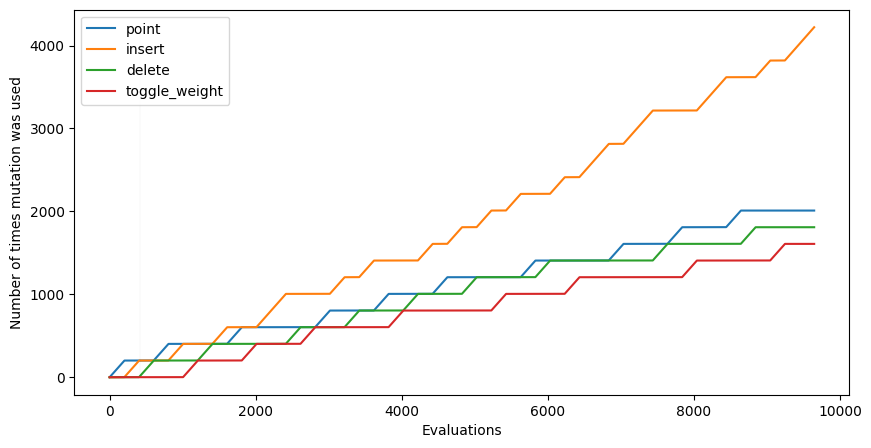

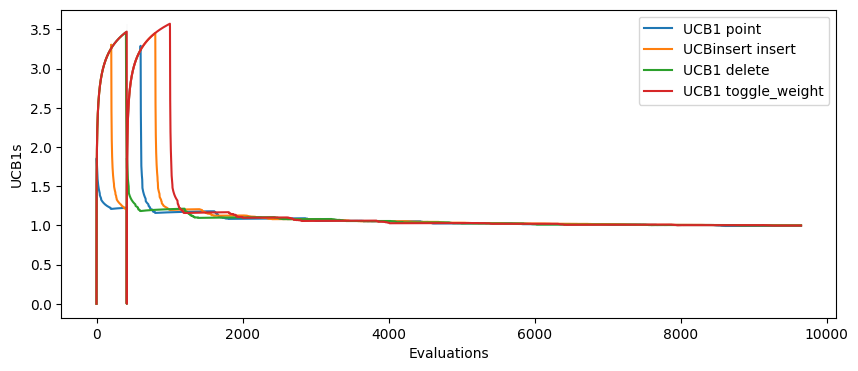

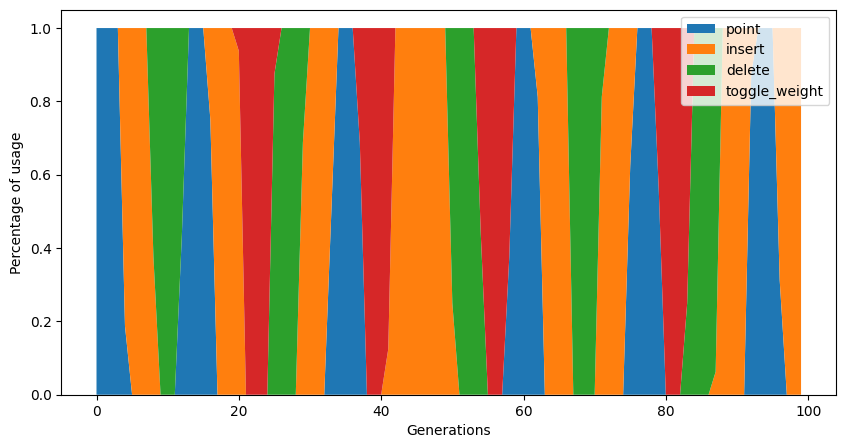

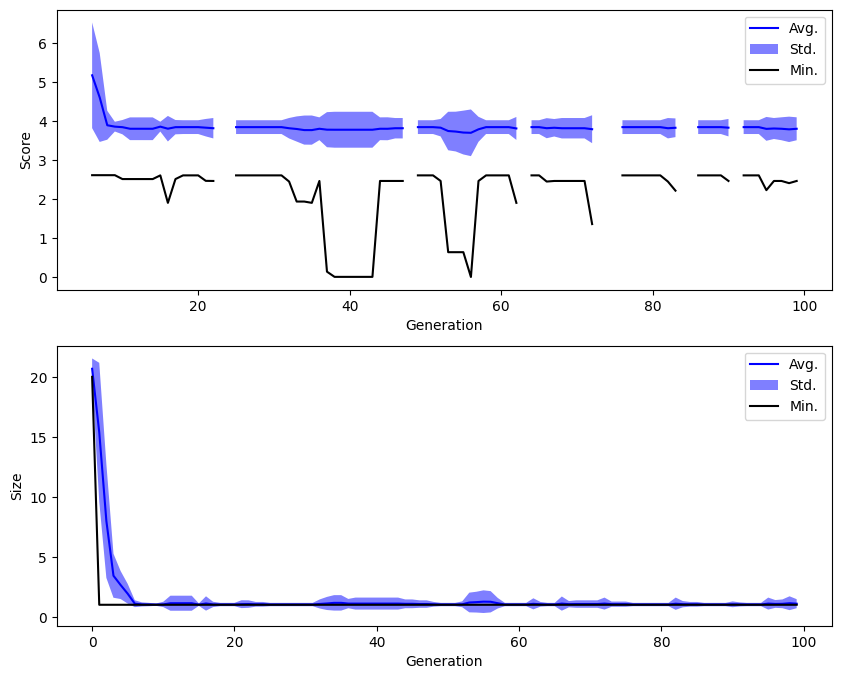

In [5]:
def generate_plots():
    !pip install matplotlib > /dev/null
    import matplotlib.pyplot as plt
    
    # plot the cumulative number of pulls (for evaluations, not generations) ---
    data = np.zeros( (learner_log.shape[0]+1, 4) )
    for i, row in learner_log.iterrows():
        data[i+1, :] = data[i]
        data[i+1, row['arm idx'].astype(int)] += 1

    plt.figure(figsize=(10, 5))

    plt.plot(data, label=est_mab.mutations_)
    plt.xlabel("Evaluations")
    plt.ylabel("Number of times mutation was used")

    # multiple lines all full height showing when D-TS used the dynamic update rule
    plt.vlines(x=[i for i, e in enumerate(learner_log['update']) if e != 0],
               ymin=0, ymax=np.max(data), colors='k', ls='-', lw=0.025)

    plt.legend()
    plt.show()

    # --------------------------------------------------------------------------
    fig, axs = plt.subplots(1, 1, figsize=(10, 4))

    columns = learner_log.columns[learner_log.columns.str.startswith('UCB1 ')]
    labels  = [columns[i].replace(str(i), est_mab.mutations_[i]) for i in range(4)] 
    data    = learner_log.loc[:, columns]

    axs.plot(data, label=labels)
    axs.set_xlabel("Evaluations")
    axs.set_ylabel(f"UCB1s")
    axs.legend()

    # multiple lines all full height showing when D-TS used the dynamic update rule
    axs.vlines(x=[i for i, e in enumerate(learner_log['update']) if e != 0],
            ymin=0, ymax=np.max(data), colors='k', ls='-', lw=0.025)

    plt.show()

    # Approximating the percentage of usage for each generation ----------------
    data = np.zeros( (kwargs['max_gen'], 4) )
    for g in range(kwargs['max_gen']):
        idx_start = g*(learner_log.shape[0]%kwargs['max_gen'])
        idx_end   = (g+1)*(learner_log.shape[0]%kwargs['max_gen'])

        df_in_range = learner_log.iloc[idx_start:idx_end]
        g_data = df_in_range['arm idx'].value_counts(normalize=True).to_dict()
        for k, v in g_data.items():
            data[g, k] = v

    plt.figure(figsize=(10, 5))

    #plt.plot(data, label=est_mab.mutations_)
    plt.stackplot(range(kwargs['max_gen']), data.T, labels=est_mab.mutations_)
    plt.xlabel("Generations")
    plt.ylabel("Percentage of usage")

    plt.legend()
    plt.show()

    # --------------------------------------------------------------------------
    logbook = pd.DataFrame(columns=['gen', 'evals', 'ave m1', 'ave m2',
                                    'std m1', 'std m2', 'min m1', 'min m2'])
    for item in est_mab.logbook_:
        # I'll store the calculate
        logbook.loc[item['gen']] = (
            item['gen'], item['evals'], *item['ave'], *item['std'], *item['min']
        )

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    x = logbook['gen']
    for i, metric in enumerate(['m1', 'm2']):
        y     = logbook[f'ave {metric}']
        y_err = logbook[f'std {metric}']
        y_min = logbook[f'min {metric}']

        axs[i].plot(x, y, 'b', label='Avg.')
        axs[i].fill_between(x, y-y_err, y+y_err, fc='b', alpha=0.5, label="Std.")
        axs[i].plot(x, y_min, 'k', label='Min.')

        axs[i].set_xlabel("Generation")
        axs[i].set_ylabel("Score" if metric=='m1' else "Size")
        axs[i].legend()

    plt.show()

generate_plots()

## Classification problem

In [6]:
if __name__ == '__main__':
    from brush import BrushClassifier
    
    import warnings
    warnings.filterwarnings("ignore")

    from pmlb import fetch_data

    # X, y = fetch_data('adult', return_X_y=True, local_cache_dir='./')

    data = pd.read_csv('../../docs/examples/datasets/d_analcatdata_aids.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'verbosity' : False,
        'pop_size'  : 100,
        'max_gen'   : 100,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    results = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
         ('Original', 'size'),  ('Original', 'depth'), 
         ('Modified', 'score'), ('Modified', 'best model'), 
         ('Modified', 'size'),  ('Modified', 'depth'), 
         ('Modified', 'point mutation calls'),
         ('Modified', 'insert mutation calls'),
         ('Modified', 'delete mutation calls'),
         ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')

            est = BrushClassifier(**kwargs).fit(X,y)
            est_mab = BrushClassifierMod(**kwargs).fit(X,y)

            learner_log = pd.DataFrame(est_mab.learner_.pull_history).set_index('t')
                        
            total_rewards = learner_log.groupby('arm idx')['reward'].sum().to_dict()
            total_pulls   = learner_log['arm idx'].value_counts().to_dict()
            
            results.loc[f'run {i}'] = [
                # Original implementation
                est.score(X,y), est.best_estimator_.get_model(),
                est.best_estimator_.size(), est.best_estimator_.depth(),

                # Implementation using Dynamic Thompson Sampling
                est_mab.score(X,y), est_mab.best_estimator_.get_model(), 
                est_mab.best_estimator_.size(), est_mab.best_estimator_.depth(),
                
                # Mutation count
                *total_pulls.values()]
            
        except Exception as e:
            print(e)

    # Showing results and statistics
    display(results)
    display(results.describe())

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 


Brush version Original                                                      
metric           score                                         best model   
run 0             0.76  Logistic(1.00*Sub(1.00*Sum(0.08*AIDS,2.24,2.24...  \
run 1             0.68                           Sum(0.22,0.00*AIDS,0.18)   
run 2             0.64                     Logistic(0.63*Sin(-0.18*AIDS))   
run 3             0.68                          Mean(0.32,0.00*AIDS,0.87)   
run 4             0.84  Sqrtabs(Median(Cos(Mean(2.13*AIDS,-863.26)),0....   
run 5             0.64                           Logistic(Tan(1.00*AIDS))   
run 6             0.80  Tanh(Median(Sin(Ceil(Sin(-0.13*AIDS))),Log(0.0...   
run 7             0.74  Logistic(-1.41*Sin(1.00*Min(531.53*Tan(Total),...   
run 8             0.78  Logistic(Exp(Mean(Add(-8.01*Total,11667.90*AID...   
run 9             0.68                    Mean(0.00*AIDS,1.06,0.66,-0.14)   
run 10            0.78              Logabs(Div(-1317.10*AIDS,0.55*Total))   
run 11            0.72  Logistic(Add(Sin(Median(0.64*AIDS,0.00*AIDS)),...   
run 12            0.88  Median(0.00*AIDS,Min(Sinh(Sinh(Max(Sin(-0.91*T...   
run 13            0.70     Sum(0.21,Max(Cos(Sqrt(0.98*AIDS)),-1.55),0.22)   
run 14            0.68                               Sub(0.00*AIDS,-0.40)   
run 15            0.66      Mul(If(AIDS>68817.00,1746.09,0.05*AIDS),0.00)   
run 16            0.82  Median(Total,0.00*AIDS,Cos(Median(1.00*AIDS,Ab...   
run 17            0.90  Max(Sin(-2.29*AIDS),Sin(Sum(-2.29*AIDS,0.23)),...   
run 18            0.86  Median(Cos(Ceil(0.48*AIDS)),0.67,0.00*AIDS,Log...   
run 19            0.78                Logabs(Div(634.53*AIDS,0.26*Total))   
run 20            0.78  Logistic(Sum(9477.80*AIDS,1.00,-6.76*Total,351...   
run 21            0.76  Min(2.12,0.74,Div(Mean(19743.03,1409.15*AIDS),...   
run 22            0.68                               Mean(0.79,0.00*AIDS)   
run 23            0.84  Logistic(Cos(Sum(Sin(-0.01*AIDS),If(AIDS>68817...   
run 24            0.84  Median(Max(0.00*AIDS,1.53,1.00,1.00),-0.81,-0....   
run 25            0.80  Cos(Sum(1.00*AIDS,AIDS,1.00*Total,Max(0.00*AID...   
run 26            0.68                                Add(0.00*AIDS,0.40)   
run 27            0.76  Logistic(Sum(1.00,59.30*AIDS,62.52*AIDS,If(AID...   
run 28            0.78  Logistic(Min(Logabs(If(AIDS>68817.00,Total,1.7...   
run 29            0.78          Logistic(Sub(Abs(-2.09*AIDS),0.00*Total))   

Brush version            Modified   
metric        size depth    score   
run 0            8     3     0.78  \
run 1            4     1     0.72   
run 2            3     2     0.78   
run 3            4     1     0.68   
run 4            8     4     0.78   
run 5            3     2     0.68   
run 6            9     5     0.80   
run 7            6     4     0.78   
run 8            7     4     0.78   
run 9            5     1     0.68   
run 10           4     2     0.70   
run 11           8     4     0.74   
run 12          20     6     0.78   
run 13           8     4     0.74   
run 14           3     1     0.72   
run 15           5     2     0.82   
run 16          12     6     0.76   
run 17          11     3     0.78   
run 18           8     3     0.82   
run 19           4     2     0.68   
run 20           6     2     0.78   
run 21           9     3     0.76   
run 22           3     1     0.80   
run 23          18     8     0.68   
run 24          11     3     0.78   
run 25          12     4     0.76   
run 26           3     1     0.68   
run 27           8     3     0.78   
run 28          18     6     0.76   
run 29           5     3     0.68   

Brush version                                                                 
metric                                                best model size depth   
run 0          Median(Prod(14.57,0.00*AIDS),Sqrtabs(-0.00*AID...   12     2  \
run 1          Logistic(Cos(Sqrtabs(If(AIDS>68817.00,-0.00*AI...   11     7   
run 2          Sin(Sqrtabs(Log1p(S

Brush version   Original                         Modified              
metric             score       size      depth      score       size   
count          30.000000  30.000000  30.000000  30.000000  30.000000  \
mean            0.757333   7.766667   3.133333   0.748667   7.300000   
std             0.073105   4.621414   1.775957   0.046589   4.900035   
min             0.640000   3.000000   1.000000   0.680000   2.000000   
25%             0.680000   4.000000   2.000000   0.705000   3.250000   
50%             0.770000   7.500000   3.000000   0.760000   6.000000   
75%             0.800000   9.000000   4.000000   0.780000  11.000000   
max             0.900000  20.000000   8.000000   0.820000  18.000000   

Brush version                                                         
metric             depth point mutation calls insert mutation calls   
count          30.000000             30.00000             30.000000  \
mean            3.233333           3343.30000           2532.600000   
std             2.095699            335.85374            221.446281   
min             1.000000           2814.00000           2211.000000   
25%             2.000000           3065.25000           2412.000000   
50%             2.500000           3216.00000           2512.500000   
75%             4.750000           3567.75000           2613.000000   
max             8.000000           4020.00000           3015.000000   

Brush version                                                     
metric        delete mutation calls toggle_weight mutation calls  
count                     30.000000                    30.000000  
mean                    2070.300000                  1701.800000  
std                      183.992532                   240.351381  
min                     1608.000000                  1206.000000  
25%                     2010.000000                  1608.000000  
50%                     2010.000000                  1809.000000  
75%                     2211.000000                  1809.000000  
max                     2412.000000                  2010.000000

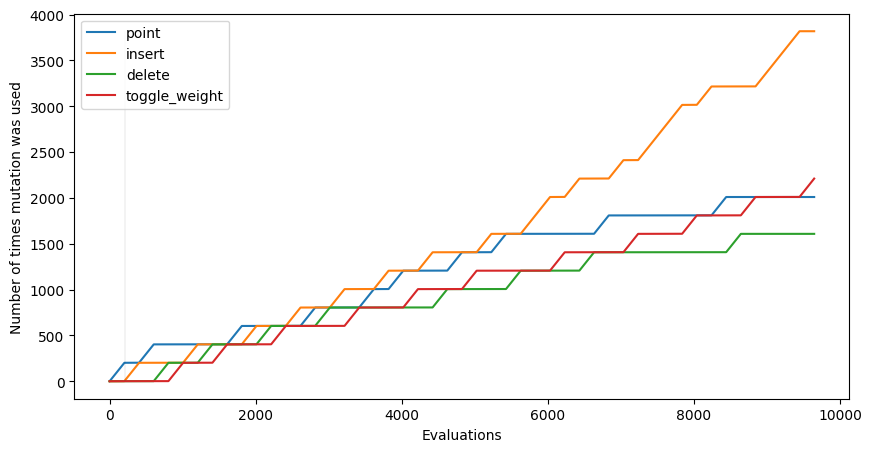

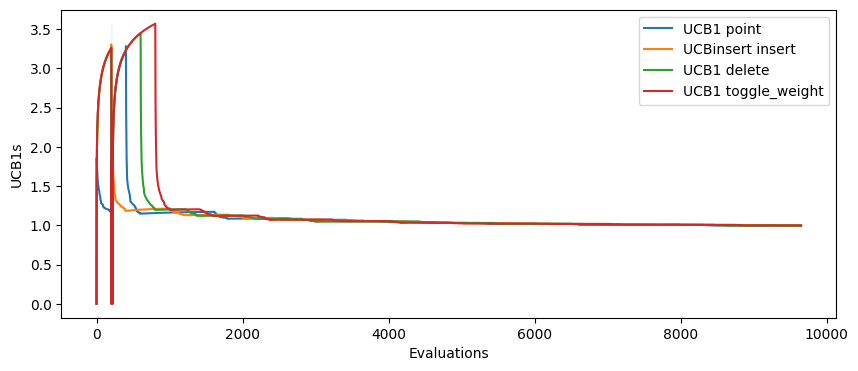

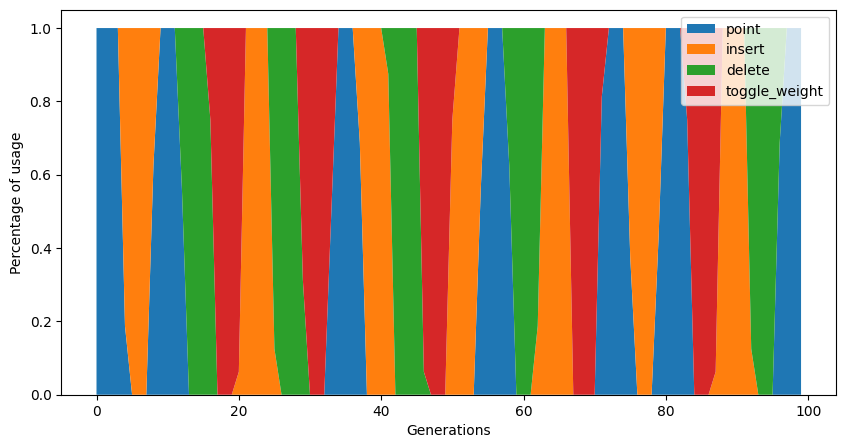

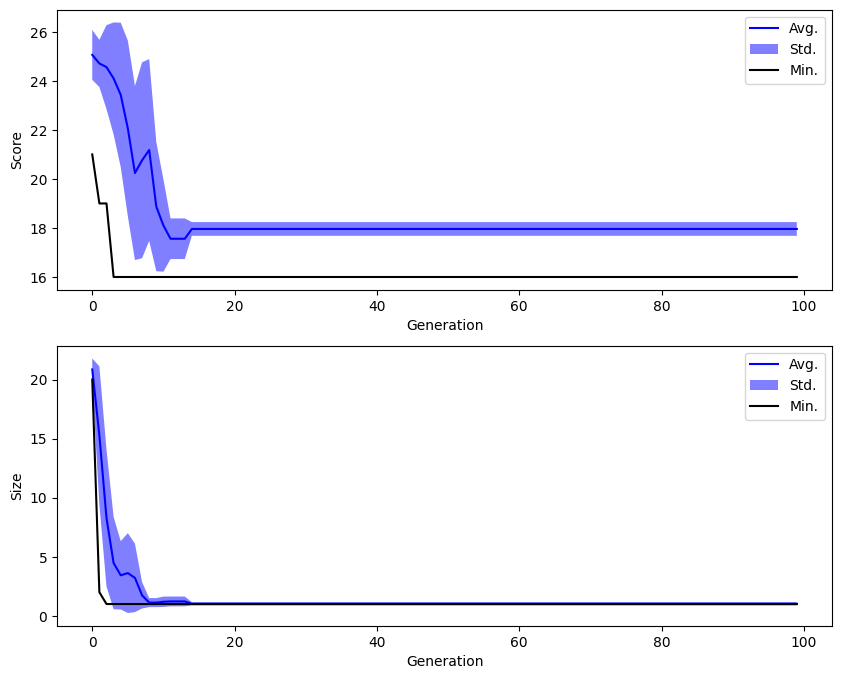

In [7]:
generate_plots()